# Sulfuric acid

First, load the necessary Python packages:

In [9]:
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
import pytzer as pz

## Dissociation measurements

### Expected degree of dissociation

First, we:

* Load the database of bisulfate dissociation measurements;
* Calculate the degree of dissociation for each measurement that is expected from CRP94.

In [2]:
# Load dataset
disbase = pz.data.dis('E:/Dropbox/_UEA_MPH/pitzer-spritzer/python/datasets/')

# Select dict of Pitzer model coefficients to use: Clegg et al. (1994)
cf = pz.cdicts.CRP94

# Solve for [H+] expected from CRP94
disbase['mH_sim'] = pz.data.dis_sim_H2SO4(np.vstack(disbase.TSO4.values),disbase.t.values,cf)

# Calculate other variables corresponding to this [H+]
disbase['mHSO4_sim'] = 2*disbase.TSO4 - disbase.mH_sim
disbase['mSO4_sim' ] = disbase.mH_sim - disbase.TSO4
disbase['a_bisulfate_sim'] = disbase.mSO4_sim / disbase.TSO4
disbase['Da_bisulfate_sim'] = disbase.a_bisulfate - disbase.a_bisulfate_sim

### Pitzer model coefficients from the data

Next, we solve the dissociation measurements to find the best-fit $\beta$ and $C$ values for H-HSO$_4$ and H-SO$_4$. We exclude some highly discrepant data points from MPH56 and HR57 studies, and use only data within 5 K of 298.15 K.

In [3]:
# Exclude bad data
QC_H2SO4 = np.logical_not(np.logical_or( \
    np.logical_and(disbase.src == 'HR57', disbase.sqm < 1),
                   disbase.src == 'MPH56'))
# Include only 298.15 +/- 5 K
LT = np.logical_and(disbase.t > 293.15, disbase.t < 303.15)
# Combine QC and T range
L = np.logical_and(QC_H2SO4,LT)

# Solve measurements for betas and Cs
bCs,bCmx = pz.fitting.bC_MNX_from_alpha(np.vstack(disbase[L].TSO4.values),
    np.vstack(disbase[L].a_bisulfate.values),disbase[L].t.values)

# Get CRP94 bC values for comparison
b0_MX,b1_MX,_,C0_MX,C1_MX,_,_,_,_ = pz.coeffs.H_HSO4_CRP94(298.15)
b0_MY,b1_MY,_,C0_MY,C1_MY,_,_,_,_ = pz.coeffs.H_SO4_CRP94 (298.15)
bCs_CRP94 = np.array([b0_MX,b1_MX,C0_MX,C1_MX,b0_MY,b1_MY,C0_MY,C1_MY])

# Print out results
print(np.vstack((bCs_CRP94,bCs)).transpose())

[[  2.95903322e-01   9.08911345e-01]
 [  4.00482398e-01  -1.02715824e+01]
 [ -5.65786652e-03  -2.80855549e-02]
 [ -4.09364247e-01   1.97070980e+00]
 [ -8.38608924e-03   4.07435123e-01]
 [  3.14734575e-01  -6.54409322e+00]
 [  1.01922474e-02  -4.51419008e-03]
 [ -3.23662604e-01  -7.89908170e+00]]


The left column above is the CRP94 coefficients at 298.15 K, while the right column shows the same coefficients calculated from the dissociation dataset. The first four rows are for H$^+$-HSO$_4^-$, while the bottom four are for H$^+$-SO$_4^-$; in both cases, the order is $\beta_0$-$\beta_1$-$C_0$-$C_1$, from top to bottom.

At a glance, there are clearly some quite substantial differences between the two sets of numbers. However, given the strong covariance between these variables, this does not necessarily mean that they will produce significantly different results when input to the Pitzer model. To assess that, we need to compare different outputs from the Pitzer model using the two different sets of coefficients, as follows.

### Expected dissociation at uniform TSO$_4$

For visualisation purposes, we set up an array of uniform TSO$_4$ values (TSO$_4$ = [HSO$_4^-$] + [SO$_4^{2-}$]) and solve the expected degree of dissociation (i.e. $\alpha$) firstly using the CRP94 Pitzer model coefficients, and secondly using those calculated from the dissocation dataset in the previous section of this analysis.

We also find the expected degree of dissociation for the actual measurements using the new fitted coefficients.

In [4]:
# Define new bC functions with fitted values
def H_HSO4_fit(T):
    
    return np.full_like(T,bCs[0], dtype='float64'), \
           np.full_like(T,bCs[1], dtype='float64'), \
           np.zeros_like(T), \
           np.full_like(T,bCs[2], dtype='float64'), \
           np.full_like(T,bCs[3], dtype='float64'), \
           np.float_(2), -9, np.float_(2.5), np.zeros_like(T, dtype='bool')

def H_SO4_fit(T):
    
    return np.full_like(T,bCs[4], dtype='float64'), \
           np.full_like(T,bCs[5], dtype='float64'), \
           np.zeros_like(T), \
           np.full_like(T,bCs[6], dtype='float64'), \
           np.full_like(T,bCs[7], dtype='float64'), \
           2 - 1842.843 * (1/T - 1/298.15), \
           -9, np.float_(2.5), np.zeros_like(T, dtype='bool')

# Insert new bC functions into a new cdict
cf_fit = pz.cdicts.cdict()
cf_fit.dh['Aosm'] = pz.coeffs.Aosm_CRP94
cf_fit.bC['H-HSO4'] = H_HSO4_fit 
cf_fit.bC['H-SO4' ] = H_SO4_fit
cf_fit.theta['HSO4-SO4'] = pz.coeffs.HSO4_SO4_CRP94
cf_fit.jfunc = pz.jfuncs.P75_eq47
cf_fit.psi['H-HSO4-SO4'] = pz.coeffs.H_HSO4_SO4_CRP94
cf_fit.K['HSO4'] = pz.coeffs.KHSO4_CRP94

# Set up uniform array of TSO4 values
sqTSO4 = np.vstack(np.linspace(0.01,np.sqrt(6),50))
TSO4 = sqTSO4**2
T = np.full_like(TSO4,298.15).ravel()

# Solve for mH
mH     = pz.data.dis_sim_H2SO4(TSO4,T,cf    )
mH_fit = pz.data.dis_sim_H2SO4(TSO4,T,cf_fit)

# Calculate other variables
mHSO4 = 2*TSO4 - mH
mSO4  = mH - TSO4
alpha = mSO4 / TSO4

mHSO4_fit = 2*TSO4 - mH_fit
mSO4_fit  = mH_fit - TSO4
alpha_fit = mSO4_fit / TSO4

mols     = np.concatenate((mH    ,mHSO4    ,mSO4    ), axis=1)
mols_fit = np.concatenate((mH_fit,mHSO4_fit,mSO4_fit), axis=1)
ions = np.array(['H','HSO4','SO4'])

acfs     = pz.model.acfs(mols    ,ions,T,cf    )
acfs_fit = pz.model.acfs(mols_fit,ions,T,cf_fit)

# Back to original measurements - solve for [H+] expected from new fitted coefficients
disbase['mH_fit'] = pz.data.dis_sim_H2SO4(np.vstack(disbase.TSO4.values),disbase.t.values,cf_fit)

# Calculate other variables corresponding to this [H+]
disbase['mHSO4_fit'] = 2*disbase.TSO4 - disbase.mH_fit
disbase['mSO4_fit' ] = disbase.mH_fit - disbase.TSO4
disbase['a_bisulfate_fit'] = disbase.mSO4_fit / disbase.TSO4
disbase['Da_bisulfate_fit'] = disbase.a_bisulfate - disbase.a_bisulfate_fit

### Investigating the kink

The simulations return a strange kink in the degree of dissociation values. Let's investigate this by fitting to artificial data with random uncertainties added.

In [5]:
# First, fit bCs to CRP94 with no uncertainties
bCs_s0 = pz.fitting.bC_MNX_from_alpha(TSO4,alpha,T)[0]

# Print out results
print(np.vstack((bCs_CRP94,bCs_s0)).transpose())

[[ 0.29590332  0.29590378]
 [ 0.4004824   0.40048714]
 [-0.00565787 -0.00565788]
 [-0.40936425 -0.40936353]
 [-0.00838609 -0.00838575]
 [ 0.31473458  0.31473649]
 [ 0.01019225  0.01019224]
 [-0.3236626  -0.32365818]]


The printout above is organised in the same way as in the earlier section on 'Pitzer model coefficients from the data'. The solved values are virtually identical to the CRP94 results. If nothing else this shows that the code executing the fitting procedure is working correctly if given perfect input data.

Next, we add a small random uncertainty to the 'measurements' and see the effect on the coefficients:

In [18]:
# Solve with added uncertainty
s1 = 0.01
alpha_s1_in = alpha + np.random.normal(loc=0, scale=s1, size=np.shape(alpha))
bCs_s1 = pz.fitting.bC_MNX_from_alpha(TSO4,alpha_s1_in,T)[0]

# Define new bC functions with fitted values
def H_HSO4_s1(T):
    
    return np.full_like(T,bCs_s1[0], dtype='float64'), \
           np.full_like(T,bCs_s1[1], dtype='float64'), \
           np.zeros_like(T), \
           np.full_like(T,bCs_s1[2], dtype='float64'), \
           np.full_like(T,bCs_s1[3], dtype='float64'), \
           np.float_(2), -9, np.float_(2.5), np.zeros_like(T, dtype='bool')

def H_SO4_s1(T):
    
    return np.full_like(T,bCs_s1[4], dtype='float64'), \
           np.full_like(T,bCs_s1[5], dtype='float64'), \
           np.zeros_like(T), \
           np.full_like(T,bCs_s1[6], dtype='float64'), \
           np.full_like(T,bCs_s1[7], dtype='float64'), \
           2 - 1842.843 * (1/T - 1/298.15), \
           -9, np.float_(2.5), np.zeros_like(T, dtype='bool')

# Insert new bC functions into a new cdict
cf_s1 = pz.cdicts.cdict()
cf_s1.dh['Aosm'] = pz.coeffs.Aosm_CRP94
cf_s1.bC['H-HSO4'] = H_HSO4_s1
cf_s1.bC['H-SO4' ] = H_SO4_s1
cf_s1.theta['HSO4-SO4'] = pz.coeffs.HSO4_SO4_CRP94
cf_s1.jfunc = pz.jfuncs.P75_eq47
cf_s1.psi['H-HSO4-SO4'] = pz.coeffs.H_HSO4_SO4_CRP94
cf_s1.K['HSO4'] = pz.coeffs.KHSO4_CRP94

# Solve for mH
mH_s1 = pz.data.dis_sim_H2SO4(TSO4,T,cf_s1)

# Calculate other variables
mHSO4_s1 = 2*TSO4 - mH_s1
mSO4_s1  = mH_s1 - TSO4
alpha_s1 = mSO4_s1 / TSO4

mols_s1  = np.concatenate((mH_s1,mHSO4_s1,mSO4_s1), axis=1)
acfs_s1  = pz.model.acfs(mols,ions,T,cf_s1)

# Print out results
print(np.vstack((bCs_CRP94,bCs_s1)).transpose())

[[  2.95903322e-01  -9.70194458e-02]
 [  4.00482398e-01  -1.45323622e+01]
 [ -5.65786652e-03  -5.94520075e-03]
 [ -4.09364247e-01  -8.50652804e-01]
 [ -8.38608924e-03  -3.61418304e-01]
 [  3.14734575e-01  -6.73635986e+00]
 [  1.01922474e-02   1.40319534e-02]
 [ -3.23662604e-01  -1.39405872e+01]]


### Visualising the results

Let's take a look at the measurements relative to their expected values:

<IPython.core.display.Javascript object>


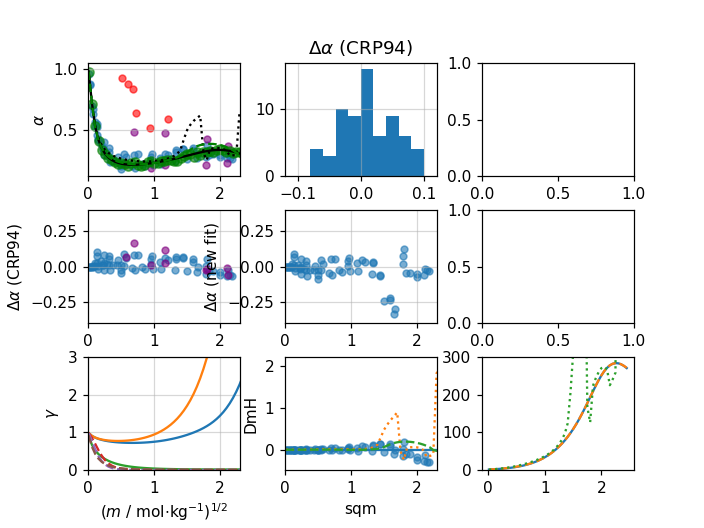

(0, 300)

In [26]:
# Set up the figure
fig,ax = plt.subplots(3,3)

ax[0,0].plot(np.sqrt(TSO4),alpha    , c='k')
ax[0,0].plot(np.sqrt(TSO4),alpha_fit, c='k', ls=':')
disbase[L].plot.scatter('sqm','a_bisulfate', ax=ax[0,0], alpha=0.6)
disbase[~QC_H2SO4].plot.scatter('sqm','a_bisulfate', ax=ax[0,0], alpha=0.6, c='r')
disbase[~LT      ].plot.scatter('sqm','a_bisulfate', ax=ax[0,0], alpha=0.6, c='purple')
ax[0,0].grid(alpha=0.5)
ax[0,0].set_xlabel(r'($m$ / mol$\cdot$kg$^{-1}$)$^{1/2}$')
ax[0,0].set_ylabel(r'$\alpha$')
ax[0,0].set_xlim((0,2.3))
ax[0,0].plot(np.sqrt(TSO4),alpha_s1 , c='g', ls='--')
ax[0,0].scatter(sqTSO4,alpha_s1_in, c='g', alpha=0.6)

disbase[ L ].plot.scatter('sqm','Da_bisulfate_sim', ax=ax[1,0], alpha=0.6)
disbase[~LT].plot.scatter('sqm','Da_bisulfate_sim', ax=ax[1,0], alpha=0.6, c='purple')
ax[1,0].grid(alpha=0.5)
ax[1,0].set_xlabel(r'($m$ / mol$\cdot$kg$^{-1}$)$^{1/2}$')
ax[1,0].set_ylabel(r'$\Delta\alpha$ (CRP94)')
ax[1,0].set_xlim((0,2.3))
ax[1,0].set_ylim((-0.4,0.4))

disbase[ L ].plot.scatter('sqm','Da_bisulfate_fit', ax=ax[1,1], alpha=0.6)
ax[1,1].grid(alpha=0.5)
ax[1,1].set_xlabel(r'($m$ / mol$\cdot$kg$^{-1}$)$^{1/2}$')
ax[1,1].set_ylabel(r'$\Delta\alpha$ (new fit)')
ax[1,1].set_xlim((0,2.3))
ax[1,1].set_ylim((-0.4,0.4))

disbase[L].hist('Da_bisulfate_sim', ax=ax[0,1], bins=np.arange(-0.12,0.12,0.02))
ax[0,1].grid(alpha=0.5)
ax[0,1].set_xlim((-0.12,0.12))
ax[0,1].set_title(r'$\Delta\alpha$ (CRP94)')

ax[2,0].plot(sqTSO4,acfs)
#ax[2,0].plot(sqTSO4,acfs_fit, ls=':')
ax[2,0].plot(sqTSO4,acfs_s1, ls='--')
ax[2,0].grid(alpha=0.5)
ax[2,0].set_xlabel(r'($m$ / mol$\cdot$kg$^{-1}$)$^{1/2}$')
ax[2,0].set_ylabel(r'$\gamma$')
ax[2,0].set_xlim((0,2.3))
ax[2,0].set_ylim((0,3))

ax[2,1].plot(sqTSO4,mH-mH)
ax[2,1].plot(sqTSO4,mH_fit-mH, ls=':')
ax[2,1].plot(sqTSO4,mH_s1-mH, ls='--')
ax[2,1].grid(alpha=0.5)
ax[2,1].set_xlabel(r'($m$ / mol$\cdot$kg$^{-1}$)$^{1/2}$')
ax[2,1].set_ylabel(r'$m$(H$^+$)')
ax[2,1].set_xlim((0,2.3))
disbase['DmH'] = disbase.mH - disbase.mH_sim
disbase[L].plot.scatter('sqm','DmH', ax=ax[2,1], alpha=0.6)

Gratio     = acfs    [:,1] / (acfs    [:,0] * acfs    [:,2])
Gratio_s1  = acfs_s1 [:,1] / (acfs_s1 [:,0] * acfs_s1 [:,2])
Gratio_fit = acfs_fit[:,1] / (acfs_fit[:,0] * acfs_fit[:,2])
ax[2,2].plot(sqTSO4,Gratio)
ax[2,2].plot(sqTSO4,Gratio_s1, ls='--')
ax[2,2].plot(sqTSO4,Gratio_fit, ls=':')
ax[2,2].set_ylim((0,300))

The 'bad' data points are clearly marked in red, while those outside the 298.15 $\pm$ 5 K temperature range are in purple. Therefore the blue points were used in the fitting process. In the top left panel, the solid black line shows results expected from CRP94, while the dashed black line shows the expected dissociation from the newly fitted coefficients.